In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mmzippy/dev-20250110T130931Z-001/dev/820.jpg
/kaggle/input/mmzippy/dev-20250110T130931Z-001/dev/dev.csv
/kaggle/input/mmzippy/dev-20250110T130931Z-001/dev/56.jpg
/kaggle/input/mmzippy/dev-20250110T130931Z-001/dev/149.jpg
/kaggle/input/mmzippy/dev-20250110T130931Z-001/dev/521.jpg
/kaggle/input/mmzippy/dev-20250110T130931Z-001/dev/185.jpg
/kaggle/input/mmzippy/dev-20250110T130931Z-001/dev/243.jpg
/kaggle/input/mmzippy/dev-20250110T130931Z-001/dev/131.jpg
/kaggle/input/mmzippy/dev-20250110T130931Z-001/dev/626.jpg
/kaggle/input/mmzippy/dev-20250110T130931Z-001/dev/641.jpg
/kaggle/input/mmzippy/dev-20250110T130931Z-001/dev/265.jpg
/kaggle/input/mmzippy/dev-20250110T130931Z-001/dev/118.jpg
/kaggle/input/mmzippy/dev-20250110T130931Z-001/dev/295.jpg
/kaggle/input/mmzippy/dev-20250110T130931Z-001/dev/668.jpg
/kaggle/input/mmzippy/dev-20250110T130931Z-001/dev/30.jpg
/kaggle/input/mmzippy/dev-20250110T130931Z-001/dev/97.jpg
/kaggle/input/mmzippy/dev-20250110T130931Z-001/dev/113.jpg


In [2]:
!pip install openpyxl
!pip install gdown
!pip install farasapy

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, Concatenate, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.applications import EfficientNetB7, MobileNetV2, ResNet50 
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import Multiply, Add

In [3]:
# Set paths for CSV and image directories
train_csv_path = '/kaggle/input/mmzippy/train-20250106T133515Z-001/train/train.csv'
dev_csv_path = '/kaggle/input/mmzippy/dev-20250106T133607Z-001/dev/dev.csv'
test_csv_path = '/kaggle/input/mmzippy/test_with_labels-20250128T173225Z-001/test_with_labels/test_with_labels.csv'

train_image_dir = '/kaggle/input/mmzippy/train-20250106T133515Z-001/train/'
dev_image_dir = '/kaggle/input/mmzippy/dev-20250106T133607Z-001/dev'
test_image_dir = '/kaggle/input/mmzippy/test-20250106T133736Z-001/test'

# Load CSV files
train_df = pd.read_csv(train_csv_path)
dev_df = pd.read_csv(dev_csv_path)
test_df = pd.read_csv(test_csv_path)

In [4]:
train_df.head()

,image_id,labels,transcriptions
0,1008,0,Sight Adichifying College Staff Expectation Re...
1,1176,1,RUKKu ioh IHL~NW irukkuzingafun irukku PHOTOUR...
2,76,0,Seven Screen Studio @7screenstudio Considering...
3,1633,0,During Farewell Girls: Boys: Pogumbodhu andha ...
4,1204,1,போஸ்ட் செய்தவர்: Posted on Qthanga456 Sharecha...


In [6]:
# Assuming train_df contains the labels in the 'labels' column
print("Number of 0s:", train_df['labels'].value_counts().get(0, 0))
print("Number of 1s:", train_df['labels'].value_counts().get(1, 0))

Number of 0s: 851
Number of 1s: 285


In [8]:
# Assuming train_df contains the labels in the 'labels' column
print("Number of 0s:", dev_df['labels'].value_counts().get(0, 0))
print("Number of 1s:", dev_df['labels'].value_counts().get(1, 0))

Number of 0s: 210
Number of 1s: 74


In [9]:
# Assuming train_df contains the labels in the 'labels' column
print("Number of 0s:", test_df['labels'].value_counts().get(0, 0))
print("Number of 1s:", test_df['labels'].value_counts().get(1, 0))

Number of 0s: 267
Number of 1s: 89


In [10]:
# Function to load image and preprocess it
def load_image(img_path):
    try:
        img = load_img(img_path, target_size=(224, 224))  # Resize image to fit EfficientNetB0
        img_array = img_to_array(img)
        img_array = img_array / 255.0  # Normalize the image
        return img_array
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None

# Function to load images from a given folder
def load_images_from_folder(image_dir, img_ids):
    images = []
    for img_id in img_ids:
        img_path = os.path.join(image_dir, f"{img_id}.jpg")  # Assuming image is in JPG format
        img = load_image(img_path)
        if img is not None:  # Check if the image was loaded successfully
            images.append(img)
    return np.array(images)

# Prepare images and labels for each dataset
train_images = load_images_from_folder(train_image_dir, train_df['image_id'])
dev_images = load_images_from_folder(dev_image_dir, dev_df['image_id'])

# Check if images were loaded successfully
if train_images.size == 0:
    print("No train images were loaded.")
if dev_images.size == 0:
    print("No dev images were loaded.")

# Prepare labels for train and dev sets
y_train = train_df['labels'].values  # Ensure 'labels' column exists
y_dev = dev_df['labels'].values

# Prepare text data (transcriptions) for each dataset
texts_train = train_df['transcriptions'].values  # Ensure 'transcriptions' column exists
texts_dev = dev_df['transcriptions'].values

In [ ]:
# Load BERT tokenizer and model (Multilingual BERT for Tamil language)
bert_model_name = 'l3cube-pune/tamil-bert'  # mBERT for multilingual support
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = TFBertModel.from_pretrained(bert_model_name)

# Custom BERT Layer
class BERTLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(BERTLayer, self).__init__(**kwargs)
        self.bert_model = bert_model
    
    def call(self, inputs):
        input_ids, attention_mask = inputs
        output = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        return output.pooler_output  # Optionally: output.last_hidden_state for sequence-level tasks

# Image model (EfficientNetB0 backbone)
image_input = Input(shape=(224, 224, 3), name="image_input")
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_tensor=image_input)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Text model (BERT processing)
MAX_LENGTH = 128  # Define maximum length for text sequences

text_input_ids = Input(shape=(MAX_LENGTH,), dtype=tf.int32, name="text_input_ids")
text_attention_mask = Input(shape=(MAX_LENGTH,), dtype=tf.int32, name="text_attention_mask")

# Pass text inputs through BERT model
bert_output = BERTLayer(bert_model)([text_input_ids, text_attention_mask])
y = Dense(512, activation='relu')(bert_output)
y = BatchNormalization()(y)
y = Dropout(0.4)(y)
y = Dense(256, activation='relu')(y)
y = BatchNormalization()(y)
y = Dropout(0.2)(y)

# Cross-Modal Fusion with Attention
def cross_modal_attention(image_features, text_features):
    """Applies cross-modal attention between image and text features."""
    # Compute attention scores
    attention_image_to_text = Dense(256, activation="softmax")(image_features)
    attention_text_to_image = Dense(256, activation="softmax")(text_features)

    # Weighted fusion
    attended_image = Multiply()([image_features, attention_text_to_image])
    attended_text = Multiply()([text_features, attention_image_to_text])

    # Concatenate attended features
    fused_features = Concatenate()([attended_image, attended_text])
    return fused_features

# Apply cross-modal fusion
fused_features = cross_modal_attention(x, y)

# Final dense layers
z = Dense(256, activation='relu')(fused_features)
z = Dropout(0.3)(z)
z = Dense(128, activation='relu')(z)
z = Dropout(0.2)(z)
z = Dense(1, activation='sigmoid')(z)  # Sigmoid output for binary classification

# Create the final model
model = Model(inputs=[image_input, text_input_ids, text_attention_mask], outputs=z)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',         
    factor=0.5,                 
    patience=3,                 
    min_lr=1e-7,                
    verbose=1                    
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

# Preprocessing function for BERT tokenizer
def preprocess_text_with_bert_tokenizer(texts, tokenizer, max_length):
    """Preprocess text data using BERT tokenizer."""
    encoding = tokenizer(
        texts.tolist(),
        return_tensors="tf",
        padding='max_length',
        max_length=max_length,
        truncation=True
    )
    return encoding['input_ids'], encoding['attention_mask']

# Preprocess train and validation texts
train_input_ids, train_attention_mask = preprocess_text_with_bert_tokenizer(train_df['transcriptions'], bert_tokenizer, MAX_LENGTH)
dev_input_ids, dev_attention_mask = preprocess_text_with_bert_tokenizer(dev_df['transcriptions'], bert_tokenizer, MAX_LENGTH)


tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.41M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/951M [00:00<?, ?B/s]

In [ ]:
# Prepare the training data (assuming train_images and dev_images are preprocessed image arrays)
X_train = {
    "image_input": train_images,  # Preprocessed images
    "text_input_ids": train_input_ids,  # Input ids from BERT tokenizer
    "text_attention_mask": train_attention_mask  # Attention mask for BERT
}
X_dev = {
    "image_input": dev_images,  # Preprocessed images
    "text_input_ids": dev_input_ids,  # Input ids from BERT tokenizer
    "text_attention_mask": dev_attention_mask  # Attention mask for BERT
}

# Labels
y_train = train_df['labels'].values  # Binary labels
y_dev = dev_df['labels'].values

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_dev, y_dev),
    epochs=100,
    batch_size=8,
    callbacks=[early_stopping, lr_scheduler]
)

In [49]:
# Predict on the validation set
y_pred_probs = model.predict(X_dev)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Print classification report
print("Validation Report:")
print(classification_report(y_dev, y_pred, target_names=['Class 0', 'Class 1']))

# Calculate and print overall metrics
accuracy = accuracy_score(y_dev, y_pred)
precision = precision_score(y_dev, y_pred)
recall = recall_score(y_dev, y_pred)
f1 = f1_score(y_dev, y_pred)

print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")
print(f"Overall F1-Score: {f1:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step 
Validation Report:
              precision    recall  f1-score   support

     Class 0       0.74      1.00      0.85       210
     Class 1       0.00      0.00      0.00        74

    accuracy                           0.74       284
   macro avg       0.37      0.50      0.43       284
weighted avg       0.55      0.74      0.63       284

Overall Accuracy: 0.7394
Overall Precision: 0.0000
Overall Recall: 0.0000
Overall F1-Score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 703ms/step
Validation Report:
              precision    recall  f1-score   support

     Class 0       0.75      1.00      0.86       267
     Class 1       0.00      0.00      0.00        89

    accuracy                           0.75       356
   macro avg       0.38      0.50      0.43       356
weighted avg       0.56      0.75      0.64       356



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


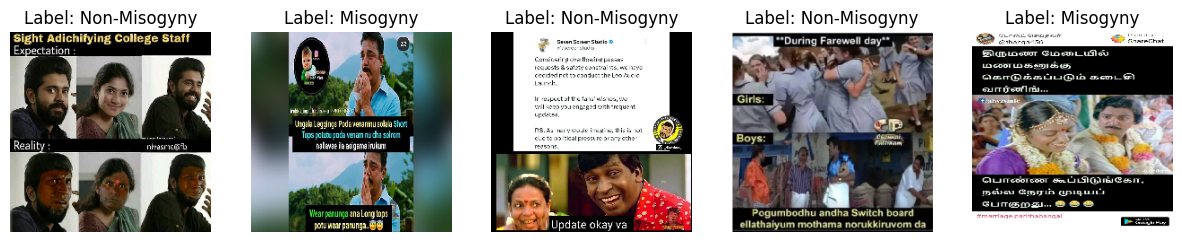

In [50]:
# Prepare test images and text data
test_images = load_images_from_folder(test_image_dir, test_df['image_id'])

# Preprocess test text data with BERT tokenizer
test_input_ids, test_attention_mask = preprocess_text_with_bert_tokenizer(test_df['transcriptions'], bert_tokenizer, MAX_LENGTH)


# Make predictions on the test set
X_test = {
    "image_input": test_images,
    "text_input_ids": test_input_ids,
    "text_attention_mask": test_attention_mask
}

y_test = test_df['labels'].values

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert to binary prediction (0 or 1)

# Print classification report
print("Validation Report:")
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

# Save predictions to a CSV
test_predictions = pd.DataFrame({
    'image_id': test_df['image_id'],
    'predicted_label': y_pred.flatten()  # Flatten to remove extra dimension
})

test_predictions.to_csv('/kaggle/working/Fired_from_NLP_Tamil_run1.csv', header=False, index=False)

# Display some training images and their labels
def visualize_images(image_paths, labels, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        img = load_img(image_paths[i], target_size=(224, 224))
        plt.imshow(img)
        plt.title(f"Label: {'Misogyny' if labels[i] == 1 else 'Non-Misogyny'}")
        plt.axis('off')
    plt.show()

# Visualize some images
sample_image_paths = [os.path.join(train_image_dir, f"{img_id}.jpg") for img_id in train_df['image_id'].head(5)]
visualize_images(sample_image_paths, y_train[:5])


In [51]:
# Calculate and print the F1 score separately
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.0000
